# Making Art with EPA SWMM

After a hard day of H&H modeling, some of us may need to express ourselves with the other side of our brain. Let's play around with a model and make some useless but interesting visualizations. We'll need a few hidden features in swmmio: the {py:func}`swmmio.utils.functions.rotate_model` and {py:func}`swmmio.utils.spatial.centroid_and_bbox_from_coords` functions.

We'll start with the `jersey` example model. 

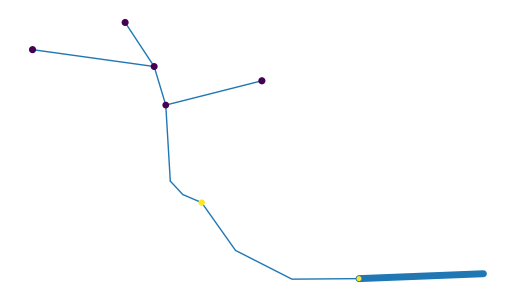

In [1]:
import numpy as np
import pandas as pd

import swmmio
from swmmio.examples import jersey
from swmmio.utils.functions import rotate_model
from swmmio.utils.spatial import centroid_and_bbox_from_coords

ax = jersey.links.geodataframe.plot(linewidth=jersey.links.dataframe['Geom1'], capstyle='round')
jersey.nodes.geodataframe.plot('MaxDepth', ax=ax, markersize='InvertElev', zorder=2)

# hide the axes since we're making art
ax.set_axis_off()

## But what if it was a Spirograph?
What happens if we spin the model around a bunch and replot it on the same figure? Would it be cool?

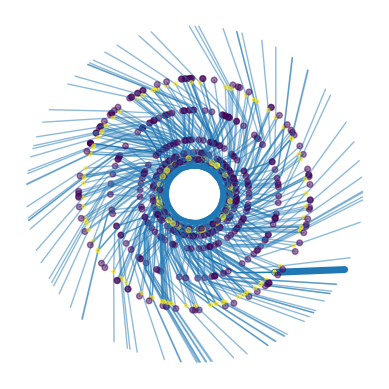

In [2]:
# first we'll get the centroid and the bounding box of the model 
# this is useful for rotating the model about its centroid
(xc, yc), [x1, y1, x2, y2] = centroid_and_bbox_from_coords(jersey.inp.coordinates)

# start the plot as usual
ax = jersey.links.geodataframe.plot(linewidth=jersey.links.dataframe['Geom1'], capstyle='round')
jersey.nodes.geodataframe.plot('MaxDepth', ax=ax, markersize='InvertElev', zorder=2)

# spin that thing around
for rads in np.arange(0, 3*3.14, 0.1):
    jersey = rotate_model(jersey,rads=rads, origin=(xc, yc))
    jersey.links.geodataframe.plot(linewidth=1, capstyle='round', ax=ax, alpha=0.5)
    jersey.nodes.geodataframe.plot('MaxDepth', ax=ax, markersize='InvertElev', zorder=2, alpha=0.5)

ax.set_axis_off()

Pretty cool. But what if we wasted more compute by making a 5x more stamps of the model. And what if we shifted the origin about which we rotate the model before each iteration?

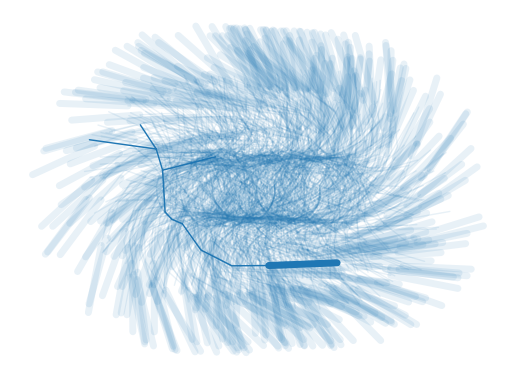

In [3]:
# refresh the model 
jersey = swmmio.Model(jersey.inp.path)

# start the plot as usual
ax = jersey.links.geodataframe.plot(linewidth=jersey.links.dataframe['Geom1'], capstyle='round')
# jersey.nodes.geodataframe.plot('MaxDepth', ax=ax, markersize='InvertElev', zorder=2)

# spin that thing around
for rads in np.arange(0, 6*3.14, 0.05):
    jersey = rotate_model(jersey, rads=rads, origin=(xc+rads*50, yc))
    jersey.links.geodataframe.plot(linewidth=jersey.links.dataframe['Geom1'], capstyle='round', ax=ax, alpha=0.1)

ax.set_axis_off()

Now we are talking. 

## Fractals?
Let's see if we can take this a bit further by generating fractals from our SWMM model. We'll need a couple more functions for shifting and shrinking the model. We'll also need to determine the top-of-shed nodes - this is where we can repeat the fractal pattern. 

Let's start by defining a function to scale the model coordinates:

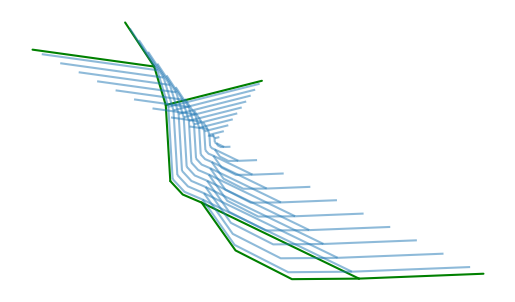

In [4]:
def scale_model_coords(model, scale_factor, center_point):
    """
    Apply a scaling factor to all coordinates in the model, such that the coordinates
    appear to shrink or expand about a given center point.

    Parameters
    ----------
    model : swmmio.Model
        The SWMM model whose coordinates are to be scaled.
    scale_factor : float
        The factor by which to scale the coordinates.
    center_point : tuple
        The (x, y) point about which to scale the coordinates.

    Returns
    -------
    swmmio.Model
        The model with scaled coordinates.
    """
    def scale_coordinates(coords, scale_factor, center_point):
        coords = np.array(coords)
        center_point = np.array(center_point)
        scaled_coords = center_point + scale_factor * (coords - center_point)
        return scaled_coords.tolist()

    model.inp.coordinates = pd.DataFrame(
        data=scale_coordinates(model.inp.coordinates.values, scale_factor, center_point),
        columns=model.inp.coordinates.columns,
        index=model.inp.coordinates.index
    )
    model.inp.vertices = pd.DataFrame(
        data=scale_coordinates(model.inp.vertices.values, scale_factor, center_point),
        columns=model.inp.vertices.columns,
        index=model.inp.vertices.index
    )
    model.inp.polygons = pd.DataFrame(
        data=scale_coordinates(model.inp.polygons.values, scale_factor, center_point),
        columns=model.inp.polygons.columns,
        index=model.inp.polygons.index
    )
    return model


# let's see if that worked
jersey = swmmio.Model(jersey.inp.path)
(xc, yc), [x1, y1, x2, y2] = centroid_and_bbox_from_coords(jersey.inp.coordinates)

# start the plot as usual
ax = jersey.links.geodataframe.plot(color='green', capstyle='round')

# scale the model a bunch of times and plot it
for scale in np.arange(0.05, 1, 0.1):
    jersey = swmmio.Model(jersey.inp.path)
    jersey = scale_model_coords(jersey, scale, (xc, yc))
    jersey.links.geodataframe.plot(ax=ax, alpha=0.5)

ax.set_axis_off()


Nice. Now let's define a function to shift the model

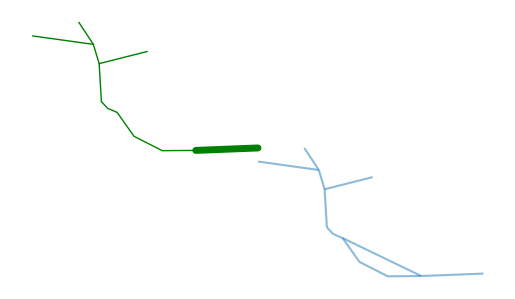

In [5]:
def shift_model_coords(model, new_center_point, anchor_point=None):
    """
    Shift all coordinates in the model to a new center point, optionally anchoring
    the shift relative to another point.

    Parameters
    ----------
    model : swmmio.Model
        The SWMM model whose coordinates are to be shifted.
    new_center_point : tuple
        The (x, y) point to which the coordinates will be shifted.
    anchor_point : tuple, optional
        The (x, y) point relative to which the shift will be anchored. If not provided,
        the current center point of the model's coordinates will be used.

    Returns
    -------
    swmmio.Model
        The model with shifted coordinates.
    """
    def shift_coordinates(coords, shift_vector):
        coords = np.array(coords)
        shifted_coords = coords + shift_vector
        return shifted_coords.tolist()

    # Calculate the current center point or use the anchor point
    if anchor_point is None:
        current_center_point = model.inp.coordinates.mean().values
    else:
        current_center_point = np.array(anchor_point)

    # Calculate the shift vector
    shift_vector = np.array(new_center_point) - current_center_point

    # Apply the shift to all coordinates
    model.inp.coordinates = pd.DataFrame(
        data=shift_coordinates(model.inp.coordinates.values, shift_vector),
        columns=model.inp.coordinates.columns,
        index=model.inp.coordinates.index
    )
    model.inp.vertices = pd.DataFrame(
        data=shift_coordinates(model.inp.vertices.values, shift_vector),
        columns=model.inp.vertices.columns,
        index=model.inp.vertices.index
    )
    model.inp.polygons = pd.DataFrame(
        data=shift_coordinates(model.inp.polygons.values, shift_vector),
        columns=model.inp.polygons.columns,
        index=model.inp.polygons.index
    )
    return model


jersey = swmmio.Model(jersey.inp.path)
(xc, yc), [x1, y1, x2, y2] = centroid_and_bbox_from_coords(jersey.inp.coordinates)

# start the plot as usual
ax = jersey.links.geodataframe.plot(color='green', linewidth=jersey.links.geodataframe['Geom1'], capstyle='round')

for outfall, _ in jersey.inp.outfalls.iterrows():
    jersey = shift_model_coords(jersey, (jersey.inp.coordinates.loc[outfall].X, jersey.inp.coordinates.loc[outfall].Y), anchor_point=(x1, y2))
    jersey.links.geodataframe.plot(ax=ax, alpha=0.5)

ax.set_axis_off()

Perfect. Now we can shift, scale, and rotate our model. All we need to do now is recursively iterator over the top-of-shed nodes and perform these actions. 

We'll use the {py:func}`swmmio.Model.network` method to access the model as a graph. Then we'll locate the top-of-shed nodes according to each node's in_degree. 


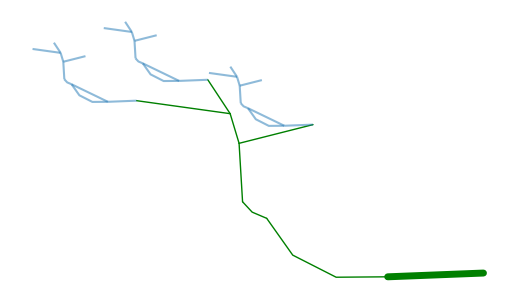

In [6]:
import networkx as nx
jersey = swmmio.Model(jersey.inp.path)
G = jersey.network

# find nodes with zero in-degree
zero_indegree = [n for n in G.nodes() if G.in_degree(n) == 0]

# start the plot as usual
ax = jersey.links.geodataframe.plot(color='green', linewidth=jersey.links.geodataframe['Geom1'], capstyle='round')

for node, row in jersey.inp.coordinates.loc[zero_indegree].iterrows():
    jersey = swmmio.Model(jersey.inp.path)
    anchor_point = jersey.inp.coordinates.loc[jersey.inp.outfalls.index[0]][['X', 'Y']].values

    jersey = scale_model_coords(jersey, 0.3, center_point=anchor_point)
    jersey = shift_model_coords(jersey, (row.X, row.Y), anchor_point=anchor_point)
    jersey.links.geodataframe.plot(ax=ax, alpha=0.5)

ax.set_axis_off()

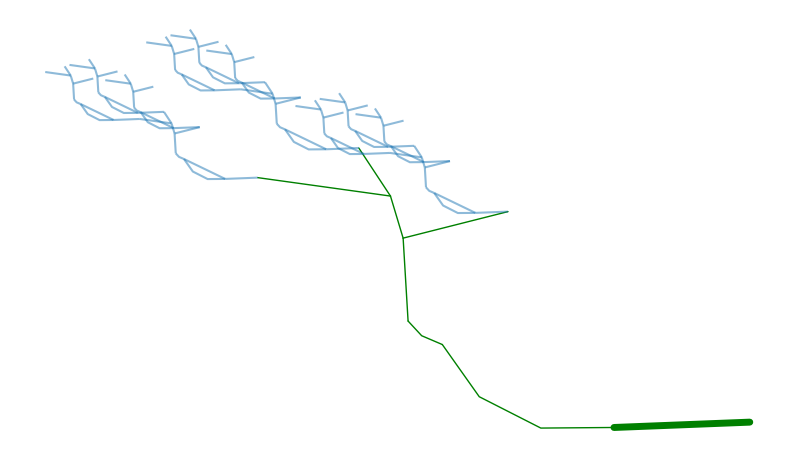

In [7]:
def plot_recursive(jersey, ax, nodes, depth, max_depth, scaler=0.8):
    if depth > max_depth:
        return

    for node, row in jersey.inp.coordinates.loc[nodes].iterrows():
        # Reload the model to avoid modifying the original
        model_copy = swmmio.Model(jersey.inp.path)
        anchor_point = model_copy.inp.coordinates.loc[model_copy.inp.outfalls.index[0]][['X', 'Y']].values

        # Scale and shift the model
        model_copy = scale_model_coords(model_copy, 0.3*scaler, center_point=anchor_point)
        model_copy = shift_model_coords(model_copy, (row.X, row.Y), anchor_point=anchor_point)

        # Plot the model
        model_copy.links.geodataframe.plot(ax=ax, alpha=0.5)

        # Find nodes with zero in-degree in the current model
        zero_indegree = [n for n in model_copy.network.nodes() if model_copy.network.in_degree(n) == 0]

        # Recur with increased depth
        plot_recursive(model_copy, ax, zero_indegree, depth + 1, max_depth, scaler=scaler*scaler)

jersey = swmmio.Model(jersey.inp.path)
# Start the plot as usual
ax = jersey.links.geodataframe.plot(color='green', linewidth=jersey.links.geodataframe['Geom1'], capstyle='round', figsize=(10, 10))

# Find nodes with zero in-degree
G = jersey.network
zero_indegree = [n for n in G.nodes() if G.in_degree(n) == 0]

# Run the recursive plotting function with a maximum depth of 3
plot_recursive(jersey, ax, zero_indegree, depth=1, max_depth=3)

ax.set_axis_off()

Lovely. Now, to wrap up, let's run this logic on another SWMM model and see how it looks

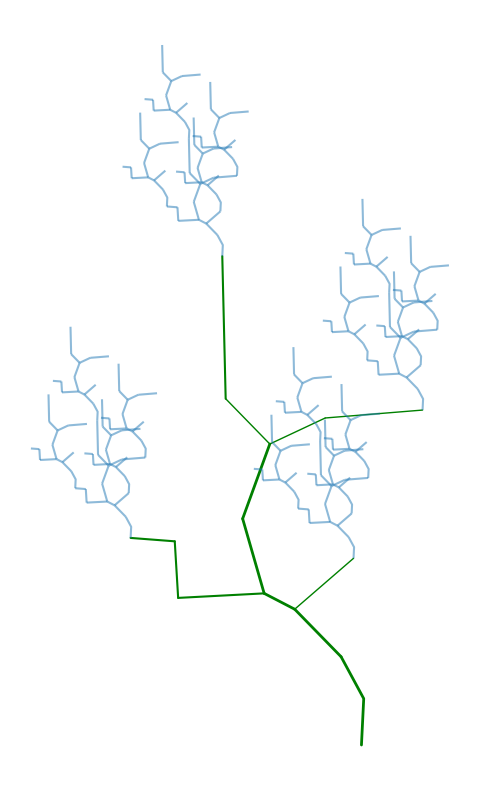

In [9]:
from swmmio.examples import walnut

walnut = swmmio.Model(walnut.inp.path)
# Start the plot as usual
ax = walnut.links.geodataframe.plot(color='green', linewidth=walnut.links.geodataframe['Geom1'], capstyle='round', figsize=(20, 10))

# Find nodes with zero in-degree
G = walnut.network
zero_indegree = [n for n in G.nodes() if G.in_degree(n) == 0]

# Run the recursive plotting function with a maximum depth of 3
plot_recursive(walnut, ax, zero_indegree, depth=1, max_depth=3)

ax.set_axis_off()